# Quantum Gaussian process regression

A proposed use of the quantum linear system solver of the previous notebook is to perform the fitting of a Gaussian process to data in a process called [quantum Gaussian process regression](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.99.052331). I will begin this section with a dive into what a classical Gaussian process is, before we introduce the quantum method.

## Gaussian processes

A Gaussian process is a probability distribution in function space, represented by an infinite dimensional Gaussian distribution. In other words, while a draw from a standard probability distribution function will return you a single point, a draw from a Gaussian process will return you a function. Like all Gaussian distributions, a Gaussian process is characterised by a mean and a covariance. We can represent a function $f$ drawn from a Gaussian process $\mathcal{GP}$ with a mean of $m$ and covariance $K$ as:

$$ f \sim \mathcal{GP}(m,K). $$

Given the dimensionality of the Gaussian distribution underlying the Gaussian process, the Gaussian process mean takes the form of a function and the covariance a square matrix of infinite size.

This is enough to describe a Gaussian process that can draw any imaginable function. However there are a couple of problems with this description so far. Firstly, practically handling mathematical objects like infinitely dimensional distributions is unwieldy as it is impossible to parametrise, given it would require an infinite number of parameters to encode the mean and covariance. And secondly, it is not well constrained; often we deal with functions that obey certain conditions, a common example is we often look for functions that are continuous and smooth. The way to get around these problems is to incorporate a kernel function kpx, x1 q to describe the Gaussian processes’ covariance over the variable x. The kernel function dictates how points in the covariance matrix relate to one another. The particular choice of kernel function encodes the constraints in functions that can be drawn from the Gaussian process.

As given by the [standard definition](https://link.springer.com/content/pdf/10.1007/b100712.pdf#page=72) - *A Gaussian process is a collection of random variables, any finite number of which have (consistent) joint Gaussian distributions.* This gives a useful property of Gaussian processes, namely that it does not matter what size the finite set of random variables it considers is, as any subset, or superset of random variables will result in a Gaussian distribution with a consistent covariance matrix. This allows us to take a finite set of data, determine the covariance matrix given the data and the assumed kernel, and make predictions using the conditioned Gaussian process on infinitely many other combinations of input variables. Let us examine how a posterior distribution can be produced on a function given a set of data and a Gaussian process as a prior to the function.

The Gaussian process prior is assumed to be:

$$ p(f) = \mathcal{GP}(m,K). $$

Consider a dataset of $N$ inputs $\mathbf{x}$ and observables $\mathbf{y}$. Here $\mathbf{x}$ is related to $\mathbf{y}$ by $\mathbf{y}=f(\mathbf{x}) + \mathbf{n}$, where $\mathbf{n}\sim\mathcal{N}(\mathbf{0},\sigma_n)$. The Gaussian process prior conditioned on this data becomes:

$$ p(f(\mathbf{x})|\mathbf{x},\mathbf{y}) = \mathcal{N}(\mathbf{y},\mathbf{K}(\mathbf{x},\mathbf{x})),$$

where:

\begin{equation}
\mathbf{K}(\mathbf{x},\mathbf{x}) =
\begin{bmatrix}
k(x_{1},x_{1}) & \dots & k(x_{N},x_{1}) \\
k(x_{1},x_{1}) & \dots & k(x_{N},x_{2}) \\
\vdots & \ddots & \vdots \\
k(x_{1},x_{N}) & \dots & k(x_{N},x_{N}) \\
\end{bmatrix},
\end{equation}

is the $ N\times N $ covariance matrix for the finite set of variables and given the kernel function $k(x,x')$ (denote this matrix as $\mathbf{K}_{\mathbf{x},\mathbf{x}}$).

With this conditioned Gaussian process, we can now consider a new finite set of input variables $\mathbf{x^{\ast}}$ of length $N^{\ast}$ and construct a posterior distribution for $f(\mathbf{x^{\ast}})$.
The mean and covariance of this new multivariate Gaussian distribution is:

$$ \mathbf{m}(\mathbf{x}^{\ast}|\mathbf{x},\mathbf{y}) = \mathbf{m}(\mathbf{x}^{\ast})+\mathbf{K}_{\mathbf{x^{\ast}},\mathbf{x}}(\mathbf{K}_{\mathbf{x,x}}+\sigma_n^{2}I)^{-1}(\mathbf{y}-\mathbf{m}(\mathbf{x})), $$

$$ \mathbf{K}(\mathbf{x^{\ast}},\mathbf{x^{\ast}}|\mathbf{x}) = \mathbf{K}_{\mathbf{x^{\ast}},\mathbf{x^{\ast}}}-\mathbf{K}_{\mathbf{x^{\ast}},\mathbf{x}} \ (\mathbf{K}_{\mathbf{x,x}}+\sigma_n^{2}I)^{-1} \ \mathbf{K}_{\mathbf{x},\mathbf{x^{\ast}}}. $$

These relations are derived using the joint model's covariance matrix:

\begin{equation}
\mathbf{K}(\{\mathbf{x}^{\ast},\mathbf{x}\},\{\mathbf{x}^{\ast},\mathbf{x}\}) =
\begin{bmatrix}
\mathbf{K}_{\mathbf{x}^{\ast},\mathbf{x}^{\ast}} & \mathbf{K}_{\mathbf{x}^{\ast},\mathbf{x}} \\
\mathbf{K}_{\mathbf{x},\mathbf{x}^{\ast}} & \mathbf{K}_{\mathbf{x},\mathbf{x}} \\
\end{bmatrix}.
\end{equation}

Given the mean and covariance the posterior distribution on $f(\mathcal{x^{\ast}})$ is simply:

$$ p(f(\mathbf{x^{\ast}})|\mathbf{x^{\ast}},\mathbf{x},\mathbf{y}) = \mathcal{N}(\mathbf{m}(\mathbf{x}^{\ast}|\mathbf{x},\mathbf{y}), \mathbf{K}(\mathbf{x^{\ast}},\mathbf{x^{\ast}}|\mathbf{x})).$$

The strength of Gaussian processes is that, as they are simply Gaussian distributions, they can be handled with linear algebra and do not require additional numerical approximations. However, as we can see in the above equations, the calculation of $(\mathbf{K}_{\mathbf{x,x}}+\sigma_n^{2}I)^{-1}$ is required, which involves inverting an ${N\times N}$ matrix. As $\mathbf{K}_{\mathbf{x,x}}+\sigma_n^{2}I$ is required to be positive semi-definite, it can be inverted using Cholesky decomposition which scales as $O(N^{3})$.

## Quantum Gaussian processes

The idea of the quamtum Gaussian process is to calculate the mean and covariance of the Gaussian process using a quantum linear system solver such as the HHL algorithm. We can relabel the variables to calrify this step. Let us define $\mathbf{u}^{T}=\mathbf{K}_{\mathbf{x^{\ast}},\mathbf{x}}$, $A=\mathbf{K}_{\mathbf{x,x}}+\sigma_n^{2}I$ and $\mathcal{v}=\mathcal{y}$, then the Gaussian process mean can be rewritten as $\mathbf{m}(\mathbf{x}^{\ast})+\mathbf{u}^{T}A^{-1}\mathbf{v}$, and similarlly letting $\mathcal{v}=\mathbf{K}_{\mathbf{x},\mathbf{x^{\ast}}}$ gives $\mathbf{K}_{\mathbf{x^{\ast}},\mathbf{x^{\ast}}}-\mathbf{u}^{T}A^{-1}\mathbf{v}$. Therefore the algorithm is structured to compute the quantity $\mathbf{u}^{T}A^{-1}\mathbf{v}$ and is repeated to return the mean and covariance.

Similarly as is described in the [original paper](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.99.052331), this is performed in five steps using four registers:

   1. Apply a Hadamard gate to the single qubit in the first register we shall call the control register to produce state: 
   
   $$|\psi_1\rangle = \left(|0\rangle_c + |1\rangle_c\right)/\sqrt{2}$$.
   
   2. Introduce the $x$ register of $n=\lceil\log_2N\rceil$ qubits and with a state preparation operation controlled on the control register, prepare the state: 
   
   $$|\psi_2\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle_c + \sum_{i=0}^{2^n-1}\frac{v_i}{\|\mathbf{v}\|}|i\rangle_x|1\rangle_c\right),$$
      
   where $\mathbf{v}=(v_i)_{i=0}^{2^n-1}$ and $\|\mathbf{v}\|=\sqrt{\sum_{i=0}^{2^n-1}|v_i|^2}$.
      
   3. Flip the control qubit with an $\hat{X}$ gate and introduce the single qubit target register, which we apply a controlled $\hat{X}$ gate to, controlled on the control register to give:

   $$|\psi_3\rangle = \frac{1}{\sqrt{2}}\left(|1\rangle_c|1\rangle_t + \sum_{i=0}^{2^n-1}\frac{v_i}{\|\mathbf{v}\|}|i\rangle_x|0\rangle_c|0\rangle_t\right),$$

   4. Perform a similar state preparation operation controlled on the control register as in step 2, but with $\mathbf{u}=(u_i)_{i=0}^{2^{n}-1}$ before flipping the controlled register back with an $\hat{X}$ gate to obtain the state:
   
   $$|\psi_4\rangle = \frac{1}{\sqrt{2}}\sum_{i=0}^{2^n-1}|i\rangle_x\left(\frac{u_i}{\|\mathbf{u}\|}|0\rangle_c|1\rangle_t + \frac{v_i}{\|\mathbf{v}\|}|1\rangle_c|0\rangle_t\right),$$
   
   
   5. Introduce an ancillary register and apply the quantum linear system solver on the $x$ register and target register, controlled on the control register qubit to prepare the state:
   
   $$|\psi_5\rangle = \frac{1}{\sqrt{2}}\sum_{i=0}^{2^n-1}|\mu_i\rangle_x\left(\frac{\gamma_i}{\|\mathbf{u}\|}|0\rangle_c|1\rangle_t + \frac{\beta_i}{\|\mathbf{v}\|}|1\rangle_c\left(\sqrt{1-(c\lambda_i^{-1})^{-2}}|0\rangle_t + c\lambda_i^{-1}|1\rangle_t\right)\right),$$
   
   where we have dropped the ancillary register and written vectors $\mathbf{u}$ and $\mathbf{v}$ in terms of coefficients $(\gamma_i)^{2^n-1}_{i=0}$ and $(\beta_i)^{2^n-1}_{i=0}$ given the set of eigenbases of $A$, $\{\mu_i\}^{2^n-1}_{i=0}$.
   
A measurement of this final state of the form $\hat{X}_c\hat{I}_x|1\rangle_t\langle1|_t$ has an expectation value:

$$ \langle\psi_5|\left(\hat{X}_c\hat{I}_x|1\rangle_t\langle1|_t\right)|\psi_5\rangle = \frac{1}{\sqrt{2}c\|\mathbf{u}\|\|\mathbf{v}\|}\sum^{2^n-1}_{i=0}\frac{\beta^{\ast}\gamma + \gamma^{\ast}\beta}{\lambda}. $$

If $\mathbf{u}$ and $\mathbf{v}$ are real vectors, then this equates to:

$$ \langle\psi_5|\left(\hat{X}_c\hat{I}_x|1\rangle_t\langle1|_t\right)|\psi_5\rangle = \frac{\sqrt{2}}{c\|\mathbf{u}\|\|\mathbf{v}\|}\sum^{2^n-1}_{i=0}\gamma\frac{\beta}{\lambda} = \frac{\sqrt{2}}{c\|\mathbf{u}\|\|\mathbf{v}\|}\mathbf{u}^TA^{-1}\mathbf{v}, $$

as desired!

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.circuit.library import StatePreparation, RYGate
from qiskit.quantum_info import Statevector
import qiskit_tools as qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from datetime import datetime

# Shake things up by changing the random seed
rseed = int(datetime.now().timestamp())
np.random.seed(rseed) 

from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
width=0.75
color='black'
fontsize=28
ticksize=22
figsize=(10,8)

We begin by setting the size of our $\mathbf{x}$ dataset $N$:

In [3]:
N = 4

which can be written on $n=\lceil\log_2N\rceil$ qubits:

In [4]:
n = int(np.ceil(np.log2(N)))

Let us consider a uniform range of $x$ data within the interval:

In [5]:
xmin, xmax = 0, 8
X_train = np.linspace(start=xmin, stop=xmax, num=2**n).reshape(-1, 1)

Now we define the functional form of $\mathbf{y}=f(\mathbf{x})$:

In [6]:
def y_targ(x):
    return np.squeeze(x*np.sin(x))

and set the standard deviation of the Gaussian noise $\sigma_n$:

In [7]:
noise_std = 0.75

and evaluate it to give:

In [8]:
y_train = y_targ(X_train) + np.random.normal(0,noise_std,N)

Now let us consider a set of $N^{\ast}$ the new $x$ points we wish to evaluate, $\mathbf{x}^{\ast}$:

In [9]:
Nast = 16

and also space these uniformly within the desired range:

In [10]:
X = np.linspace(start=xmin, stop=xmax, num=Nast).reshape(-1, 1)
y = y_targ(X)

Let us define the kernel $k(x,x')$ as:

$$ k_{SEK}(x,x') = \sigma \exp\left(-\frac{1}{2}\left(\frac{x-x'}{\ell}\right)^2\right), $$

where $\sigma$ and $\ell$ are amplitude and length scale hyperparameters. This is a common choice of kernel that asserts the function $f(x)$ to be smooth and continuous. There are a number of choices of kernels that should be considered given prior knowledge of the function that you wish to fit.

In [11]:
def SEK(X1, X2, ls=1.0, sig=1.0):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sig * np.exp(-0.5 * sqdist / ls**2)

Typically, the hyperparameters of the kernel should be chosen through an optimisation process, or ideally posteriors of which found through Bayesian inference then marginalised out. However, this is not the subject of this notebook as we wish to solely fit a Gaussian process to our data regardless of the kernel. Therefore we choose fixed values for our hyperparameters. Let us assume that the amplitude parameter is twice the variance of the noise standard deviation, and the length scale is equal to the intervals between $x^{\ast}$ data:

In [12]:
sigma = 2*noise_std
ls = 2.**(-(xmax-xmin)/Nast)

Now we can write the formula for the mean and covariance functions and define a function that evaluates them classically:

In [13]:
def posterior(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    K = SEK(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = SEK(X_train, X_s, l, sigma_f)
    K_ss = SEK(X_s, X_s, l, sigma_f)
    K_inv = np.linalg.inv(K)
    
    mu_s = K_s.T.dot(K_inv).dot(Y_train)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

Let us see what this looks like:

In [14]:
mean_prediction, cov_s = posterior(X, X_train, y_train, l=ls, sigma_f=sigma, sigma_y=noise_std)
std_prediction = np.diag(cov_s)

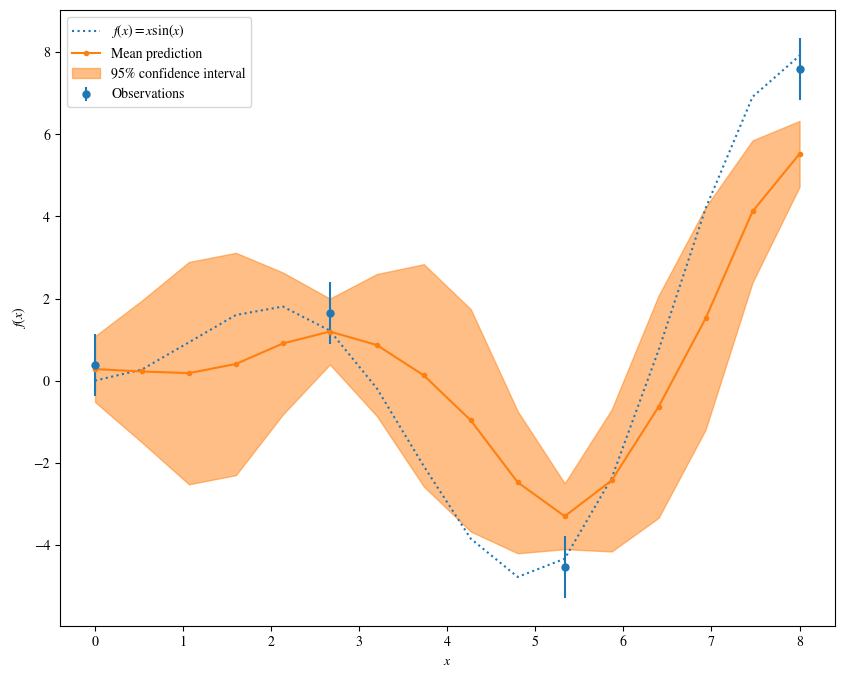

In [15]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

ax.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
ax.errorbar(
    X_train,
    y_train,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
ax.plot(X, mean_prediction, label="Mean prediction", marker='.')
ax.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")

plt.show()

The Gaussian process prediction $p(f(\mathbf{x^{\ast}})|\mathbf{x^{\ast}},\mathbf{x},\mathbf{y})$ follows the trend of the target function $f(x)$, especially at points coinciding with $\mathbf{x}$.

Now let us consider fitting this function with a quantum Gaussian process. First let us consider estimating the mean function and define our $\mathbf{v}=\mathbf{y}$, $\mathbf{u}=\mathbf{K}_{\mathbf{x,x^{\ast}}}$ and $A=\mathbf{K}_{\mathbf{x,x}}+\sigma_n^2I$:

In [16]:
# Pick the middle x* to evaluate
u_ind = (len(X)//2) - 1

# Define v and u
v = y_train
u = SEK(X, X_train, ls, sig=sigma)[u_ind]

# Determine normalisation of v and u
v_norm = np.sqrt(np.sum(np.abs(v)**2))
u_norm = np.sqrt(np.sum(np.abs(u)**2))

# Normalised vectors v and u
v_ = v/v_norm
u_ = u/u_norm

# Determine A
A = SEK(X_train, X_train, ls, sig=sigma) + (np.eye(len(X_train))*noise_std**2)

As with the previous notebooks, we will cheat and determine in advance the maximum and minimum eigenvalues, as well as the conditioning number of $A$. Then determine the minimum number of ancillary qubits from a desired phase estimation success probability, then determine the optimal evolution time from these values:

In [17]:
kappa = np.linalg.cond(A)
lambda_min = np.min(np.abs(np.linalg.eigvals(A)))
lambda_max = np.max(np.abs(np.linalg.eigvals(A)))

# Choose a success probability of determining eigenvalue estimation
p_suc = 0.99
# Determine the number of ancillary qubits to ensure the given success probability
nanc = n + int(np.ceil(np.log2(2. + 1./(2.*(1-p_suc)))))

phase = True

# Calculate the new scale of the relative magnitudes of maximum and minimum eigenvalues
rescale = int((2**(nanc-phase)-1)/kappa)
# Make sure this scaling is not vanishingly small
if rescale < 1.e-7:
    rescale = 1
    
# determine the number of integer qubits required
nint = qt.get_nint(rescale)
# Assert that the number of integer qubits is equal to or greater than the number of ancillary qubits assigned
if nint < nanc - phase:
    nint = nanc - phase
    
# We can determine the scaling of the rotation of step 3 (variable c)
scaling = qt.bin_to_dec(qt.my_binary_repr(rescale, nint=nint, n=nint, phase=False), nint=0, phase=False)
t0 = scaling / (lambda_min * (2**phase))
t = 2 * np.pi * t0

Now let us put a circuit together. We can define our four registers required (control, $x$, target and ancillary):

In [18]:
qcont = QuantumRegister(1, 'cont')
qtarg = QuantumRegister(1, 'targ')
qreg = QuantumRegister(n, 'x')
qanc = QuantumRegister(nanc, 'anc')

circ = QuantumCircuit(qanc, qtarg, qreg, qcont)

Step 1 is performed by a single Hadamard on the control qubit:

In [19]:
circ.h(qcont);
circ.barrier();

Step 2 is performed with the controlled state preparation operation of $\mathbf{v}$ (here just using qiskits `StatePreparation` operator which performs arbirtary state preparation) on the $x$ register controlled on the control qubit:

In [20]:
prepv_gate = StatePreparation(Statevector(v_)).control(1)
circ.append(prepv_gate, [qcont, *qreg]);
circ.barrier();

Step 3 flips the control qubit and performs a control NOT on the target qubit:

In [21]:
circ.x(qcont);
circ.cx(qcont, qtarg);
circ.barrier();

Step 4 performs the state preparation of $\mathbf{u}$ on the $x$ register, controlled on the control qubit before flipping the control qubit back:

In [22]:
prepu_gate = StatePreparation(Statevector(u_)).control(1)
circ.append(prepu_gate, [qcont, *qreg]);
circ.x(qcont);
circ.barrier();

The final step applies the quantum linear system solver to the $x$ and target register given $A$ controlled on the control register:

In [23]:
hhl_gate = qt.HHL(circ, qreg, qanc, qtarg, A, t=t, scaling=scaling, wrap=True).control(1)
circ.append(hhl_gate, [qcont, *qreg, *qanc, qtarg]);

This circuit is illustrated below:

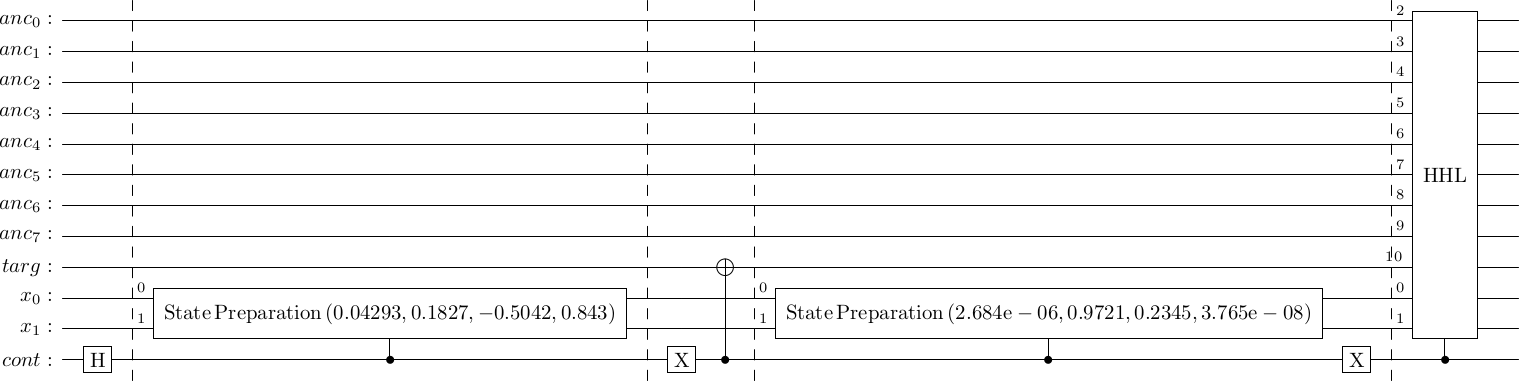

In [24]:
circ.draw('latex')

Now let us retreive the output state and compare it to our target.

In [25]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
state_vector = np.asarray(result.get_statevector())

Let us first probe into the the unnormalised state when the control and target state is measured in state $|1\rangle_c|1\rangle_t$:

In [26]:
state_v = np.asarray(state_vector).reshape((2**1, 2**n, 2**1, 2**nanc)).T
state_v = state_v[0,1,:,1]

which we can compare to the target, which equals:

In [27]:
targ_v = np.matmul(np.linalg.inv(A),v_)*np.sqrt(2.)

We compare the amplitudes to this target in the plot below, where the red markers show the target values and the black dots the resulting amplitudes. They should match relatively well!

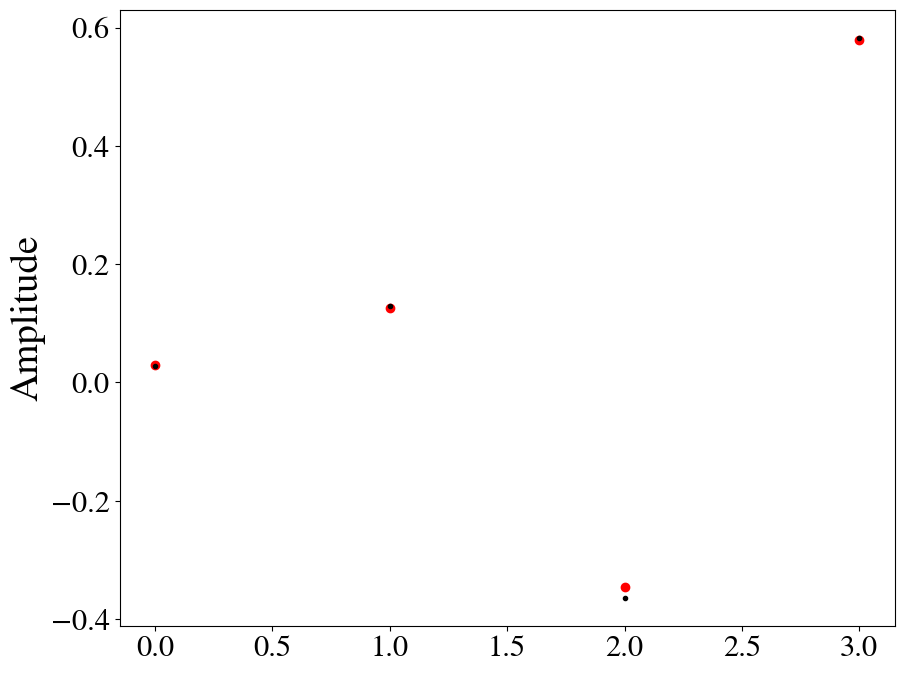

In [28]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

plt.scatter(np.arange(2**n), targ_v, marker='o', color='red')
plt.scatter(np.arange(2**n), state_v.real, marker='.', color='black')
ax.set_ylabel('Amplitude', fontsize=fontsize);
ax.tick_params(axis='both', labelsize=ticksize);

Similarly, let us look at the unnormalised amplitude when the control and target states are measured to be $|0\rangle_c|1\rangle_t$:

In [29]:
state_u = np.asarray(state_vector).reshape((2**1, 2**n, 2**1, 2**nanc)).T
state_u = state_u[0,1,:,0]

which we can compare to the target:

In [30]:
targ_u = u_/np.sqrt(2.)

Again, the overlap between the target and unnormalised output state should be good as shown in the plot below.

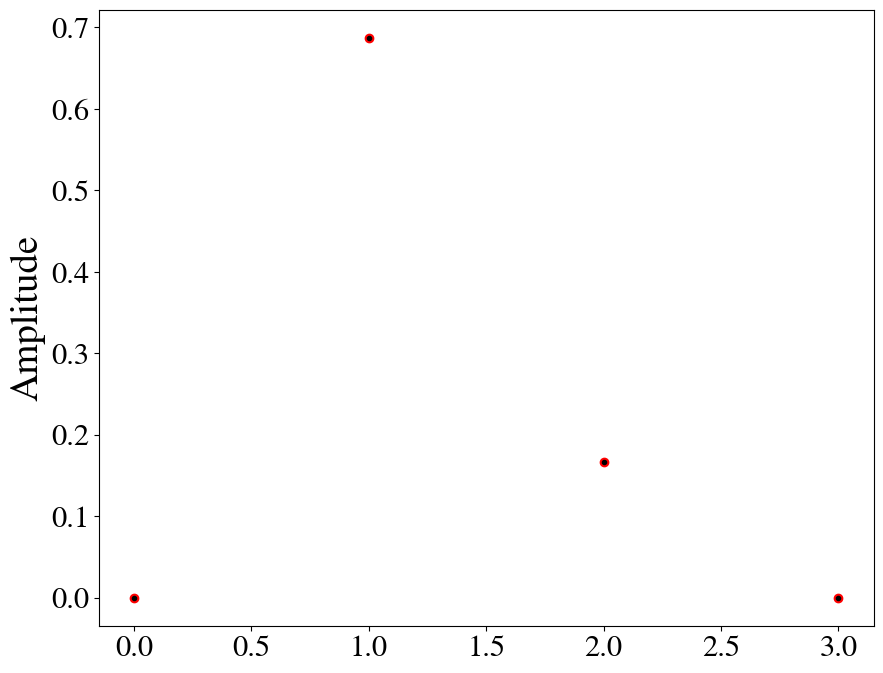

In [31]:
fig = plt.figure(figsize=np.array(figsize))
ax = fig.add_subplot(111)

plt.scatter(np.arange(2**n), targ_u, marker='o', color='red')
plt.scatter(np.arange(2**n), state_u.real, marker='.', color='black')
ax.set_ylabel('Amplitude', fontsize=fontsize);
ax.tick_params(axis='both', labelsize=ticksize);

Now let us calculate the expectation value of the measure $\hat{X}_c\hat{I}_x|1\rangle_t\langle1|_t$. We can do this by selecting the unnormalised amplitude of obtaining the state $|1\rangle_t$:

In [32]:
state_v = np.asarray(state_vector).reshape((2**1, 2**n, 2**1, 2**nanc)).T
state_v = state_v[0,1].T

and defining the $\hat{X}$ gate matrix:

In [33]:
X_matrix = np.array([[0,1],[1,0]])

The expectation value of the mean predicted by the quantum Gaussian process is then:

In [34]:
mu_out = np.matmul(state_v.flatten(),np.matmul(X_matrix, state_v.real).flatten()).real*(u_norm*v_norm*scaling/np.sqrt(2.))

We can compare the quantum prediction to that calculated classically:

In [35]:
print(mu_out, mean_prediction[u_ind])

0.1746982219057788 0.12855242787956755


Interestingly, they are not necessarily equivalent.

We can examine the quantum Gaussian process result more carefully by predicting the mean and covariance for the whole vector $\mathbf{x}^{\ast}$ (this may take some time to perform depending on $N^{\ast}$).

In [36]:
mus = []
stds = []

for i in tqdm(np.arange(Nast)):
    
    v = y_train
    u = SEK(X, X_train, ls, sig=sigma)[i]

    v_norm = np.sqrt(np.sum(np.abs(v)**2))
    u_norm = np.sqrt(np.sum(np.abs(u)**2))

    v_ = v/v_norm
    u_ = u/u_norm
    
    v_gate = StatePreparation(Statevector(v_))
    u_gate = StatePreparation(Statevector(u_))

    qcont = QuantumRegister(1, 'cont')
    qtarg = QuantumRegister(1, 'targ')
    qreg = QuantumRegister(n, 'reg')
    qanc = QuantumRegister(nanc, 'anc')

    circ = QuantumCircuit(qanc, qtarg, qreg, qcont)
        
    QGPR_gate = qt.QGPR(circ, qreg, qanc, qtarg, qcont, v_gate, u_gate, A, t, scaling, wrap=True)
    circ.append(QGPR_gate, [*qreg, *qanc, qtarg, qcont]);
    
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    state_vector = np.asarray(result.get_statevector())
    
    state_v = np.asarray(state_vector).reshape((2**1, 2**n, 2**1, 2**nanc)).T[0,1].T
    mus.append(np.matmul(state_v.flatten(),np.matmul(X_matrix, state_v.real).flatten()).real*(u_norm*v_norm*scaling/np.sqrt(2)))
    
    qcont = QuantumRegister(1, 'cont')
    qtarg = QuantumRegister(1, 'targ')
    qreg = QuantumRegister(n, 'reg')
    qanc = QuantumRegister(nanc, 'anc')

    circ = QuantumCircuit(qanc, qtarg, qreg, qcont)
        
    QGPR_gate = qt.QGPR(circ, qreg, qanc, qtarg, qcont, u_gate, u_gate, A, t, scaling, wrap=True)
    circ.append(QGPR_gate, [*qreg, *qanc, qtarg, qcont]);
    
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    state_vector = np.asarray(result.get_statevector())
    
    state_v = np.asarray(state_vector).reshape((2**1, 2**n, 2**1, 2**nanc)).T[0,1].T
    M_exp = np.matmul(state_v.flatten(),np.matmul(X_matrix, state_v.real).flatten()).real*((u_norm**2)*scaling/np.sqrt(2))

    stds.append(SEK(X, X, ls, sig=sigma)[i,i]-M_exp)
    
mus = np.array(mus)
stds = np.array(stds)

100%|███████████████████████████████████████████| 16/16 [01:45<00:00,  6.60s/it]


Let us now compare $p(f(\mathbf{x^{\ast}})|\mathbf{x^{\ast}},\mathbf{x},\mathbf{y})$ for both the quantum and classical case (purple and orange respectively).

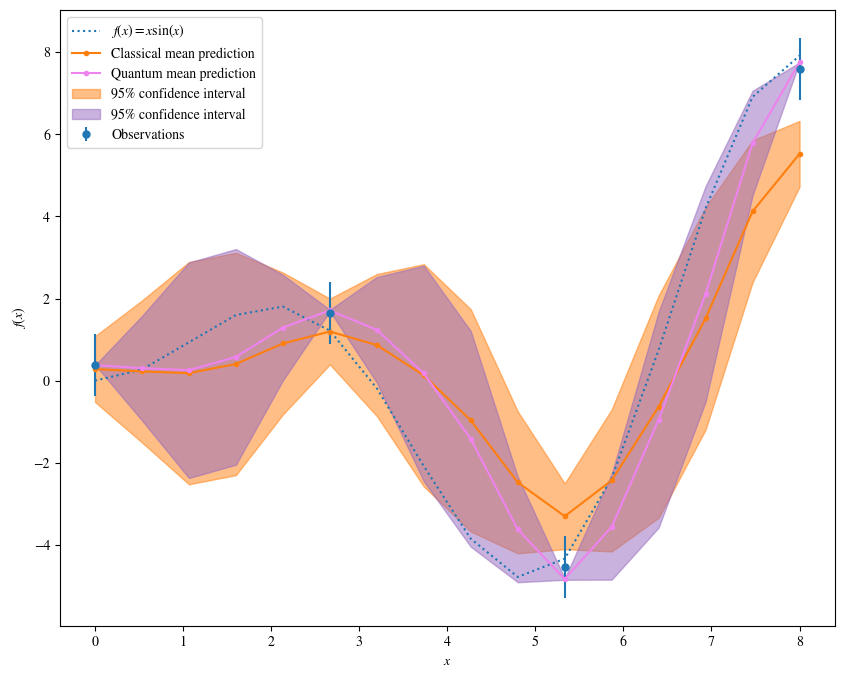

In [37]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

ax.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
ax.errorbar(
    X_train,
    y_train,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
ax.plot(X, mean_prediction, marker='.', label="Classical mean prediction")
ax.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
ax.plot(X, mus, color='violet', marker='.', label="Quantum mean prediction")
ax.fill_between(
    X.ravel(),
    mus - 1.96 * stds,
    mus + 1.96 * stds,
    color="tab:purple",
    alpha=0.5,
    label=r"95% confidence interval",
)

ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")

plt.show()

We can see that, like the classical Gaussian process, the quantum Gaussian process follows the function $f(x)$. Interestingly, it appear to perform noticably *better* than the classical case, where the quantum Gaussian process mean more closely follows the target function, and more tightly so around the observed data points. 

**Future work:** why does the quantum Gaussian process appear to perform better? Classical Gaussian processes benefit from additive white noise to better condition the matrix for the inversion process. It may be that the quantum case has an inbuilt noise addition in the process that improves the process. However, this needs more closer examination (it may be only the case for the particular example given here!).